# Kaggle Leaf Classification Challenge


In [2]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas

In [3]:
## If you are working on Colab, data_utils can be downloaded using the command below (uncomment line below)
# ! curl -O https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/6_Mini_Project/data_utils.py

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab


If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [6]:
# !ls drive/'My Drive'

Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [7]:
# drive_path = 'drive/My Drive/'
local_path = ''  # if you're folder structure is as defined above and you want to run locally

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [8]:
image_paths = glob.glob("images/*.jpg")
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [9]:
# Your code here:
def summarize_data(data):
    print("Shape:\t", data.shape)
    if 'species' in data.columns:
        summary = data.species.value_counts().value_counts()
        for i in range(len(summary)):
            print("Number of species with", summary.index[i], "observations:\t", summary.values[i])

print(f"The different columns in both sets are {train.columns.symmetric_difference(test.columns).values}")
print("--------------------")
print("Train data information:")
summarize_data(train)
print("--------------------")
print("Test data information:")
summarize_data(test)

The different columns in both sets are ['species']
--------------------
Train data information:
Shape:	 (990, 194)
Number of species with 10 observations:	 99
--------------------
Test data information:
Shape:	 (594, 193)


 * **Answer:** 990 and 594 samples in the training and test sets, respectively. We have the same information, except for the target variable, '*species*'. In the training set, we have 10 samples for each species, which there are 99 different ones. In the test set this is unknown, since this is what has to be predicted.

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

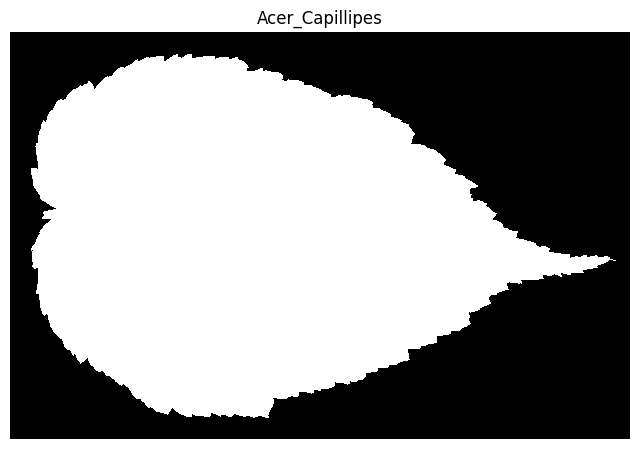

In [10]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index(local_path + 'images\\{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

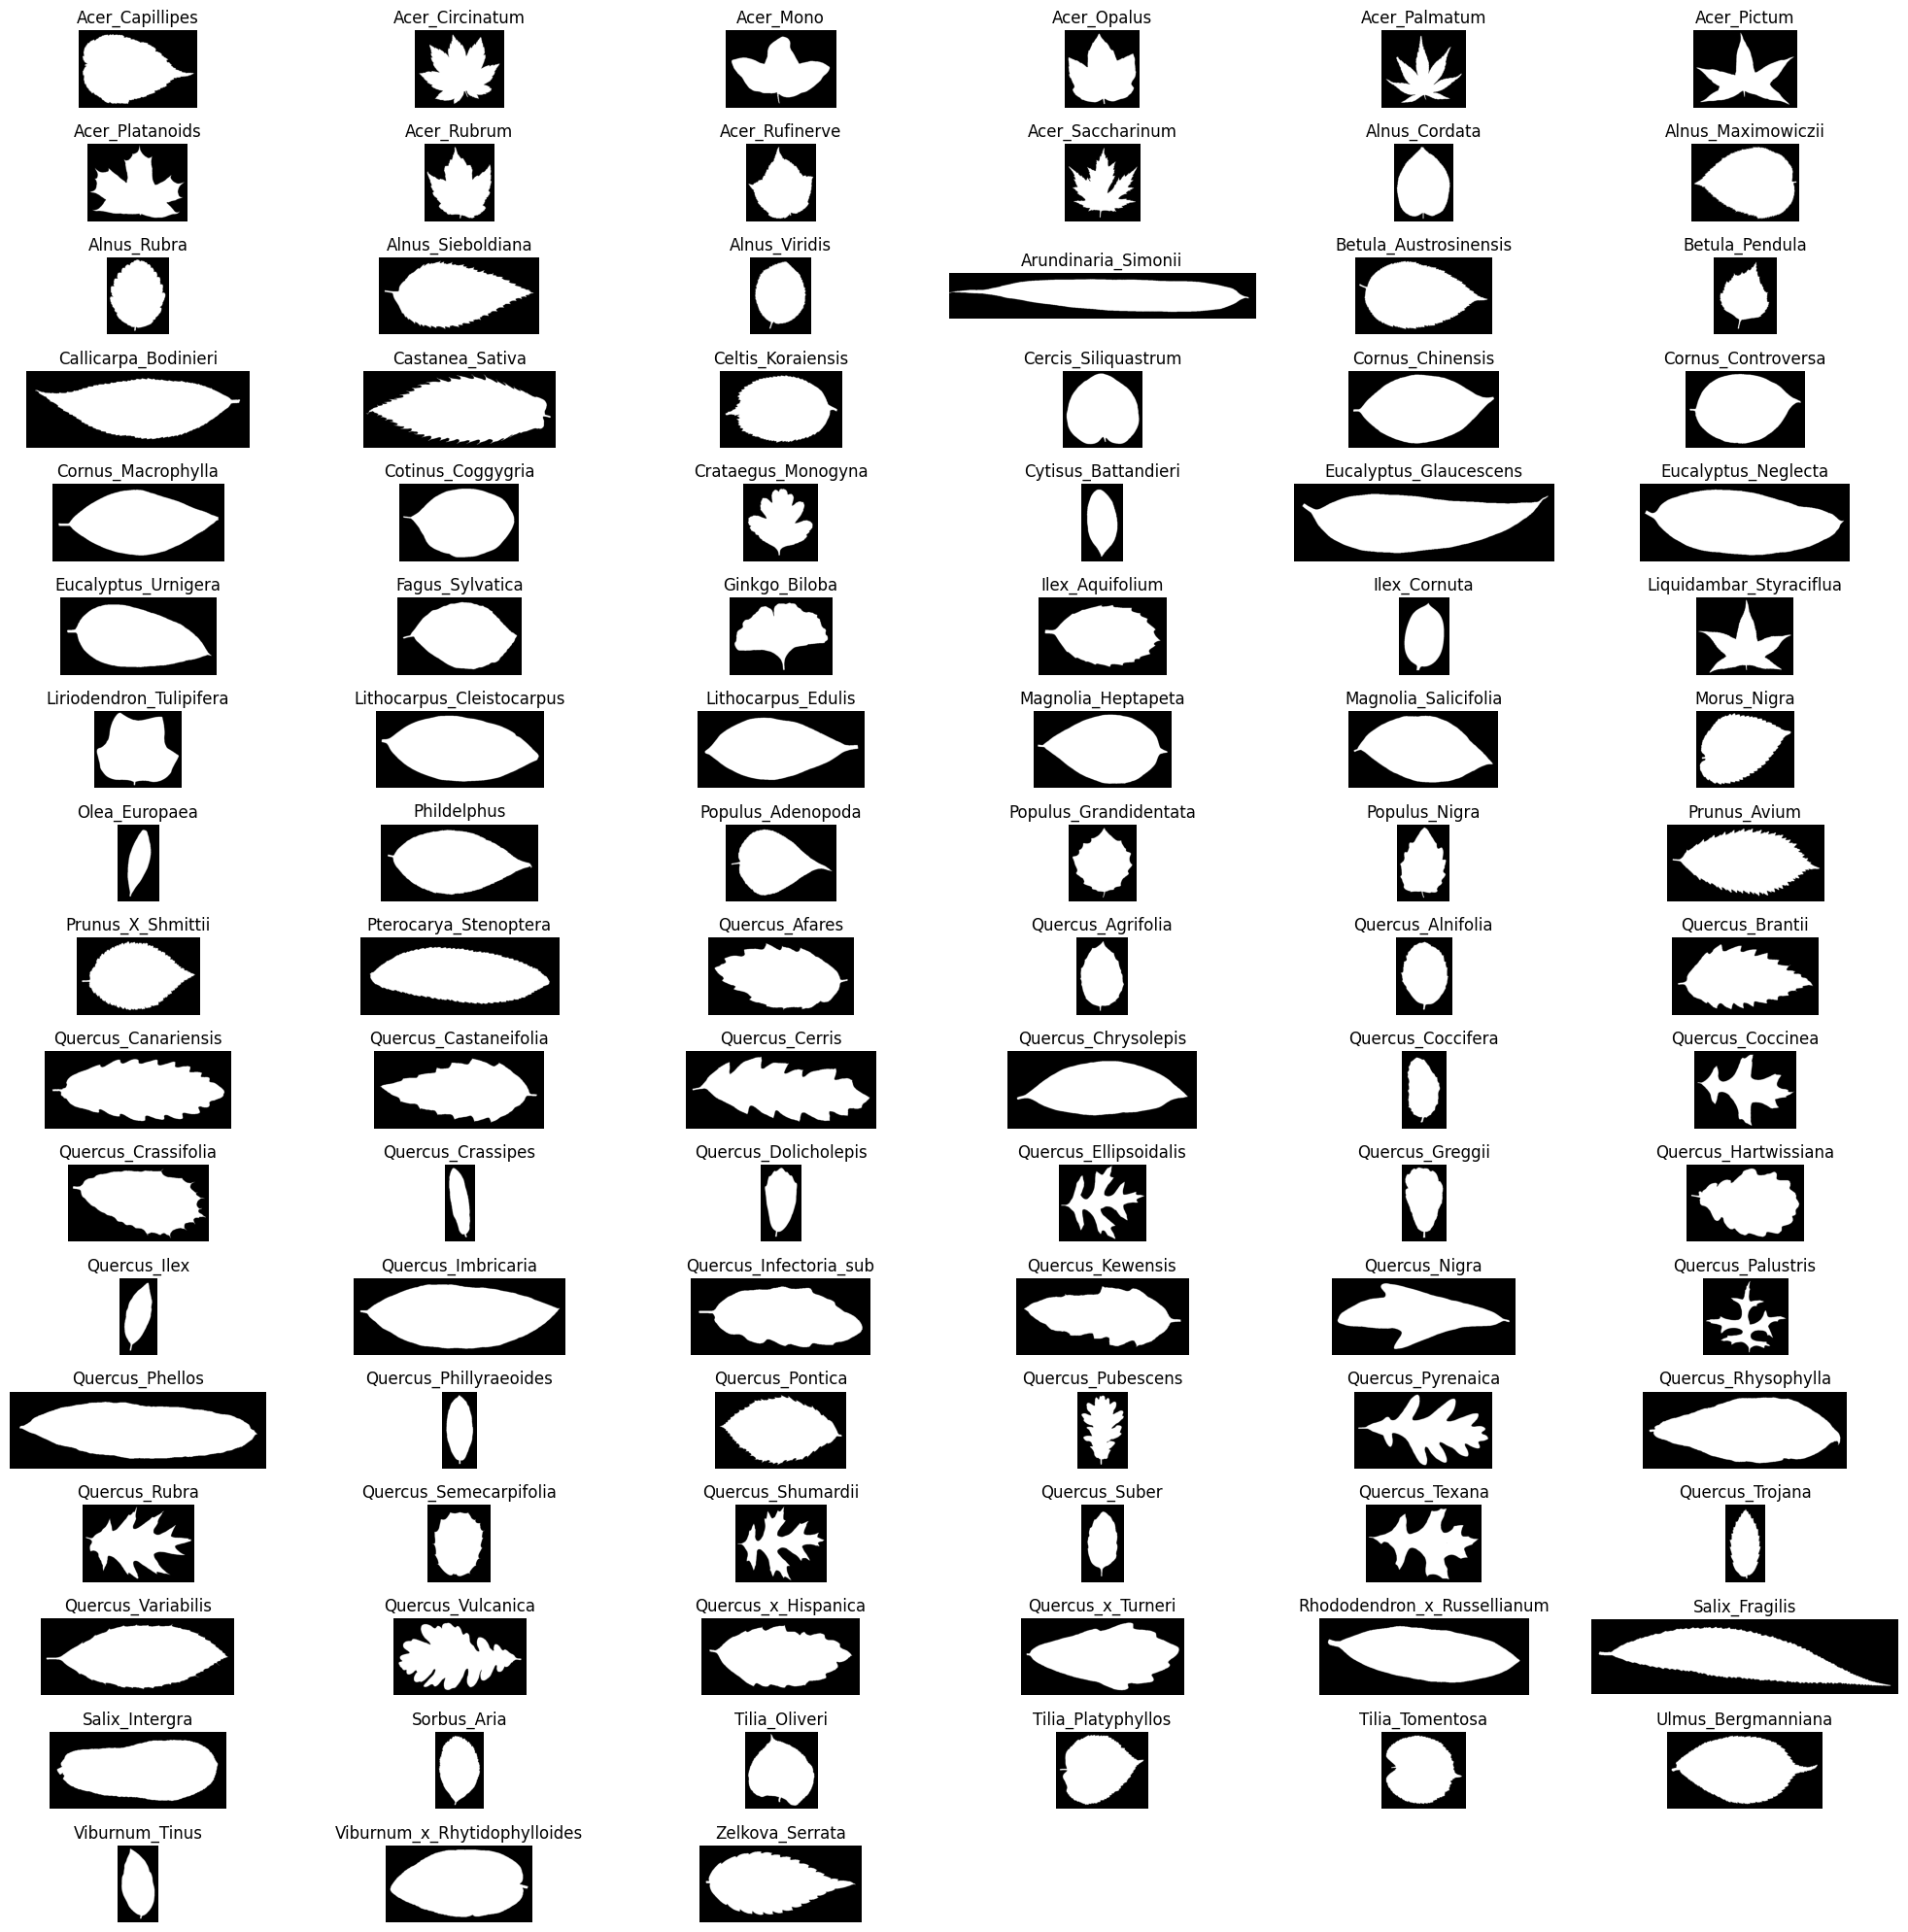

In [11]:
# Now plot 1 image from each category
ncols = 6
nrows = len(species) // ncols + 1
plt.figure(figsize=(20, 20))
for i, (species_id, index) in enumerate(zip(species, indexes)):
    plt.subplot(nrows, ncols, i + 1)
    image = imread(image_paths[index], as_gray=True)
    plt.imshow(image, cmap='gray')
    plt.title("%s" % (species_id), fontsize=12)
    plt.axis('off')
plt.tight_layout()

As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.



 * **Answer:** I've tried powers of 2, since these are the most common choices for hidden units in neural networks and have the best overall properties. Also, I choose a square shape for the resized images, because some images are vertical and some are horizontal and we don't want to over penalize one or the other. A square is also better because when we add padding we transform it into a square and after that we only have to downscale. 
 
 The first choice was 128 pixels due to it being the smallest power of 2 that conserves important details like the small spikes around the leafs, evaluated by sight (see the table below). However, after playing around with the model the choice was changed to **32 pixels**, since it allows for larger CNN models and doesn't increase the loss that much (if at all). 


|  32x32 | 64x64 | 128x128 | 256x256 |
|---|---|---|---|
|  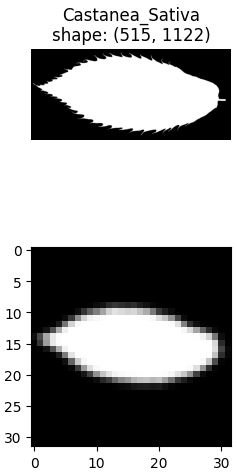 |  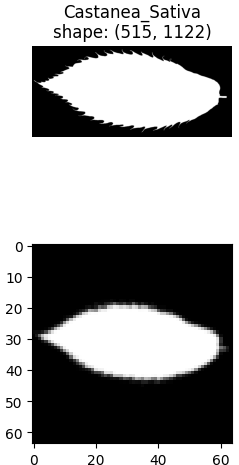 |  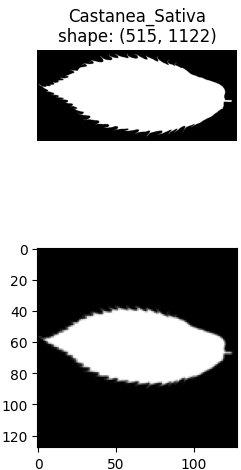  |  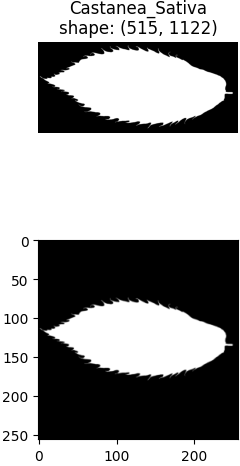 |



In [12]:
# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

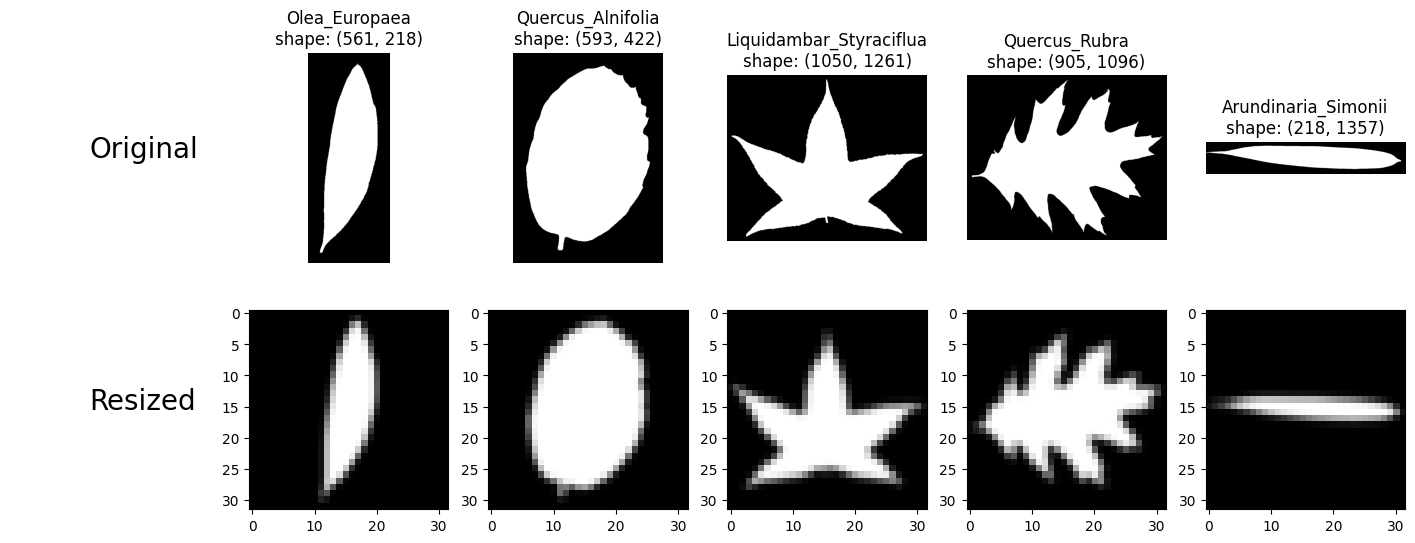

In [13]:
## Image pre-processing
SQUARE_SIZE = 32
image_size = (SQUARE_SIZE, SQUARE_SIZE)  # <-- YOUR CODE HERE

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

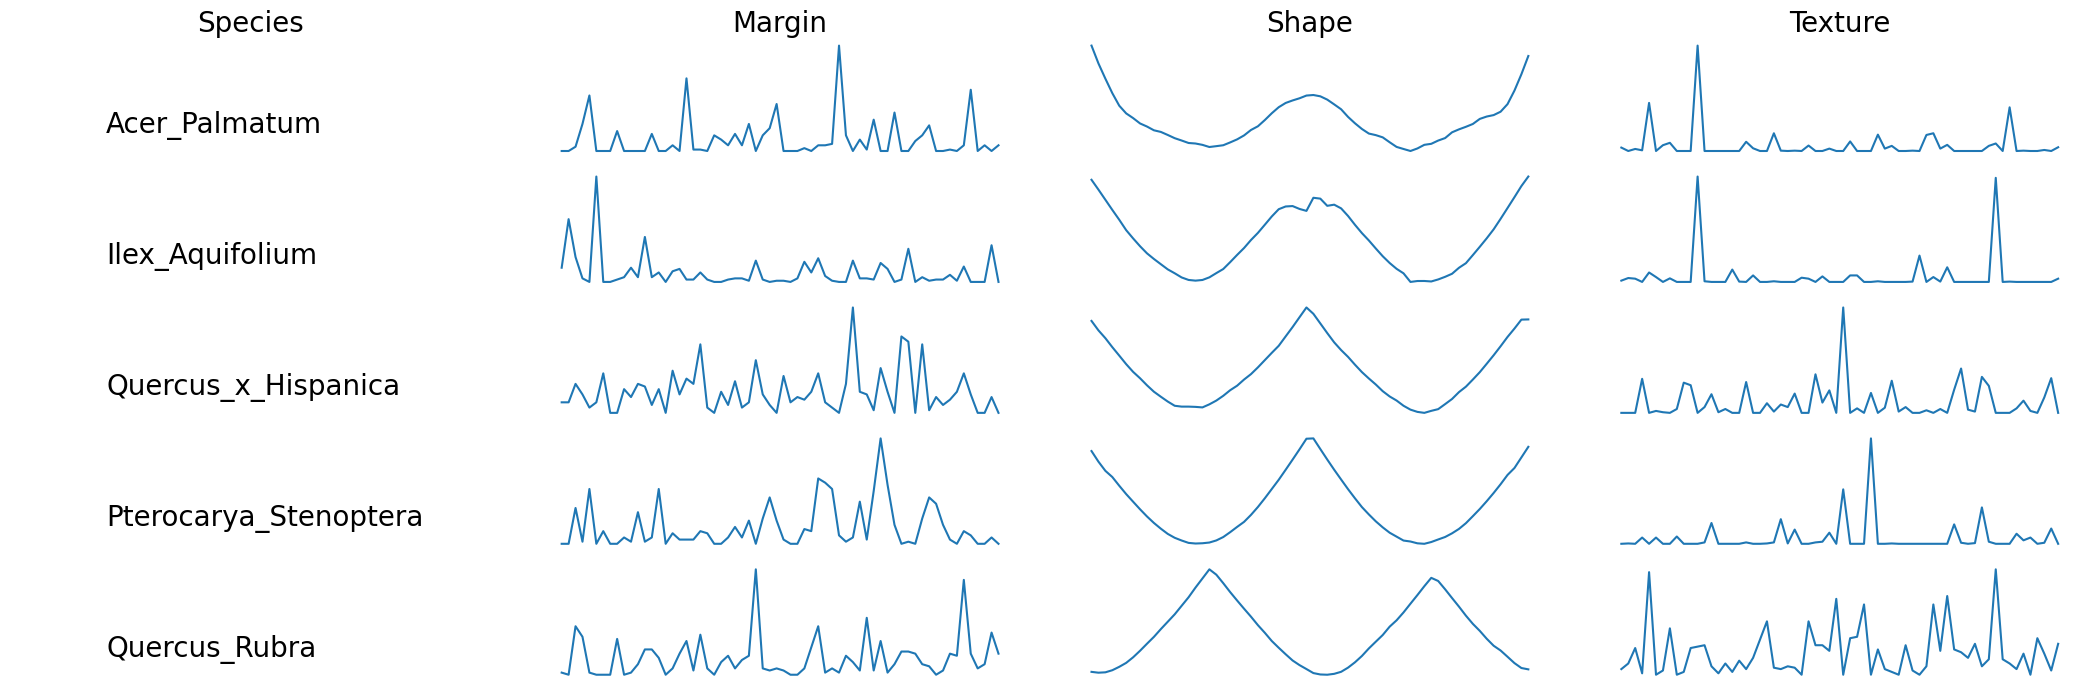

In [14]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:** 
- `image`: I would use a **CNN** on it, since it's an image and we want to capture the spatial relation between the pixels. Also, we want that the orientation of the shape (horizontal vs vertical) doesn't affect the results.
- `Shape`: I would use a **RNN**(LSTM or GRU) on it, since it seems to be a cycle of a periodic function. This choice would capture the long-range dependencies between the data, specially in the bidirectional case. A 1-D CNN is also be a possibility, but it would focus more on local patterns, which doesn't seem to be the most important information in this case. In particular, a GRU will probably be used since it uses less memory and it's faster than LSTM, which we can't take full advantage because the sequences won't be long.
- `Margin` and `Texture`: I would use **FFNN**  since they are 64-attribute vectors, without any evident properties. 
 

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [15]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE =  (SQUARE_SIZE, SQUARE_SIZE, 1)  # Resized to 128x128 pixels and grayscale
NUM_CLASSES =  train.species.value_counts().count()  # The number of species in the data

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES =  64 # Explained in the documentation of the dataset

In [16]:
# Paths to data
TRAIN_PATH = local_path + "train.csv" 
TEST_PATH = local_path + "test.csv" 
IMAGE_PATHS = glob.glob(local_path + "images/*.jpg")

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 32, 32, 1)0.281171
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 32, 32, 1)	0.281459
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


**DONE**

#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [16]:
# import pickle

# # Dump the data into a pickle file
# with open(local_path + 'data.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [3]:
# import pickle

# # # Load the data from a pickle file
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

## Batch Generator
While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.



## Exercise 6



6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

**Answer:** The size of batches affects the following elements:
 - *Memory*: larger batch sizes mean more necessary memory in the RAM or GPU, if the batch size is larger than those components can handle, the training will fail.
 - *Traning speed*: larger batch sizes mean more parallel processing, since elements from the same batch are independent from one another. However, this also means that there will be fewer iterations of backpropagation, so the convergence might be slower. In fewer words, the model will see more data in the same amount of data, but will update its weights fewer times (supposing that we only see each sample once).
 - *Estimates of the gradients*: larger batch sizes mean more accurate gradients, since there will be less variability in the batch data. However, this can also mean that it gets stuck in local minima more easily, slowing convergence.
 
 As a convention, convenient properties and for simplicity's sake, we're only gonna consider powers of 2. *Memory* is not a concern due to the small size of the dataset and the samples. At first, `16` was chosen, since it's a reasonable compromise, with 50 iteration per epoch and training speed. However, through grid search and experience in general, we increased batch size to `128`.

In [49]:
# batch_size = 16 # First choce, exercise 6
batch_size = 128
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print("\tTotal MB in memory:", sum([train_batch[key].nbytes for key in train_batch]) / 1e6)
print("\tTraining iterations per epoch:", train.shape[0] / float(batch_size))
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print("\tTotal MB in memory:", sum([valid_batch[key].nbytes for key in valid_batch]) / 1e6)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))
print("\tTotal MB in memory:", sum([test_batch[key].nbytes if type(test_batch[key]) == np.ndarray else 0  for key in test_batch]) / 1e6)

TRAIN
	images, (128, 32, 32, 1)
	margins, (128, 64)
	shapes, (128, 64)
	textures, (128, 64)
	ts, (128, 99)
	Total MB in memory: 0.67328
	Training iterations per epoch: 7.734375

VALID
	images, (99, 32, 32, 1)
	margins, (99, 64)
	shapes, (99, 64)
	textures, (99, 64)
	ts, (99, 99)
	Total MB in memory: 0.52074

TEST
	images, (128, 32, 32, 1)
	margins, (128, 64)
	shapes, (128, 64)
	textures, (128, 64)
	ids, 128
	Total MB in memory: 0.622592


# Build the model

In [19]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d, CrossEntropyLoss, LSTM
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [20]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

**Comment**: There's not much left of the original code, but you can see that the inputs and outputs have been adapted to models through `permute`, `view` and `reshape` methods.

In [21]:
def calculate_output_size(input_height, input_width, conv_out_channels, 
                          kernel_size, conv_stride, conv_pad, pool_1_kernelsize, pool_1_stride):
    # Compute the height and width after the convolutional layer
    conv_output_height = (input_height - kernel_size + 2 * conv_pad) // conv_stride + 1
    conv_output_width = (input_width - kernel_size + 2 * conv_pad) // conv_stride + 1
    
    # Compute the height and width after the pooling layer
    pool_output_height = (conv_output_height - pool_1_kernelsize) // pool_1_stride + 1
    pool_output_width = (conv_output_width - pool_1_kernelsize) // pool_1_stride + 1
    
    # Calculate the final output size after flattening
    flattened_size = pool_output_height * pool_output_width * conv_out_channels
    
    return pool_output_height, pool_output_width, flattened_size

In [22]:
HEIGHT, WIDTH, CHANNELS = IMAGE_SHAPE

class NetParameters():
    def __init__(self, useImages = True, useMarginAndTextures = True, useShapes = True, cnn_out_channels = 8, n_filters = 4, kernel_size_1 = 5, kernel_size_2 = 3, cnn_stride = 1, cnn_pad = 1, 
                 pool_1_stride = 2, pool_1_kernelsize = 2, pool_2_stride = 2, pool_2_kernelsize = 2, 
                 rnn_hidden_units = 64, ffnn_hidden_units = 2**14,
                    rnn_dropout = 0.5, ffnn_dropout = 0.5, rnn_layers = 1, rnn_bidirectional = True, rnn_only_lastlayer = False):
        self.useImages = useImages
        self.useMarginAndTextures = useMarginAndTextures
        self.useShapes = useShapes

        self.cnn_out_channels = cnn_out_channels
        self.kernel_size_1 = kernel_size_1
        self.kernel_size_2 = kernel_size_2
        self.cnn_stride = cnn_stride
        self.cnn_pad = cnn_pad
        self.pool_1_stride = pool_1_stride
        self.pool_1_kernelsize = pool_1_kernelsize
        self.pool_2_stride = pool_2_stride
        self.pool_2_kernelsize = pool_2_kernelsize
        self.rnn_hidden_units = rnn_hidden_units
        self.ffnn_hidden_units = ffnn_hidden_units
        self.ffnn_dropout = ffnn_dropout
        self.rnn_dropout = rnn_dropout
        self.rnn_layers = rnn_layers
        self.rnn_bidirectional = rnn_bidirectional
        self.rnn_only_lastlayer = rnn_only_lastlayer
        self.L = 1 if rnn_only_lastlayer else rnn_layers
        self.B = 2 if rnn_bidirectional else 1
        # Parameters for two layers in the CNN
        self.height_1, self.width_1, _  = calculate_output_size(HEIGHT, WIDTH, n_filters, kernel_size_1, cnn_stride, cnn_pad, pool_1_kernelsize, pool_1_stride)
        self.height_2, self.width_2, self.n_image_features = calculate_output_size(self.height_1, self.width_1, cnn_out_channels, kernel_size_2, cnn_stride, cnn_pad, pool_2_kernelsize, pool_2_stride)
        # Parameters for only one layer in the CNN
        # self.height_1, self.width_1, self.n_image_features  = calculate_output_size(HEIGHT, WIDTH, cnn_out_channels, kernel_size_1, cnn_stride, cnn_pad, pool_1_kernelsize, pool_1_stride)
        self.n_shape_features = self.rnn_hidden_units*self.B*self.L
        self.n_filters = n_filters

        self.features_cat_size = 0       # <-- Number of features concatenated before output layer
        if useImages:
            self.features_cat_size += self.n_image_features # image features
        if useMarginAndTextures:
            self.features_cat_size += NUM_FEATURES*2 # margin and texture features
        if useShapes:
            # self.features_cat_size += NUM_FEATURES # Try predict it with FFNN
            self.features_cat_size += self.n_shape_features

class Net(nn.Module):
    def __init__(self, params:NetParameters):
        super(Net, self).__init__()
        assert params.useImages or params.useMarginAndTextures or params.useShapes, "At least one of the feature types must be used"

        self.image_model = nn.Sequential(
            # First convolutional layer
            Conv2d(in_channels=CHANNELS,
                             out_channels=params.n_filters,
                             kernel_size=params.kernel_size_1,
                             stride=params.cnn_stride,
                             padding=params.cnn_pad),
            BatchNorm2d(params.n_filters),
            nn.ReLU(),
            MaxPool2d(kernel_size=params.pool_1_kernelsize, 
                      stride=params.pool_1_stride),
            # Second convolutional layer
            Conv2d(in_channels=params.n_filters,
                             out_channels=params.cnn_out_channels,
                             kernel_size=params.kernel_size_2,
                             stride=params.cnn_stride,
                             padding=params.cnn_pad),
            BatchNorm2d(params.cnn_out_channels),
            nn.ReLU(),
            MaxPool2d(kernel_size=params.pool_2_kernelsize, 
                      stride=params.pool_2_stride),
            # Flatten the output for each image
            nn.Flatten()
        )
        # Exercise: Add a recurrent unit like and RNN or GRU
        self.shape_model = GRU(input_size=1,
                         hidden_size=params.rnn_hidden_units,
                         num_layers=params.rnn_layers,
                         batch_first=True,
                         bidirectional=params.rnn_bidirectional,
                         dropout=params.rnn_dropout)
        self.shape_batchnorm = BatchNorm1d(NUM_FEATURES)
        # self.shape_batchnorm_2 = BatchNorm1d(params.n_shape_features)

        self.MaT_batchnorm = BatchNorm1d(NUM_FEATURES*2)

        self.out_model = nn.Sequential(
            Linear(in_features=params.features_cat_size,
                    out_features=params.ffnn_hidden_units,
                    bias=False),
            nn.ReLU(),
            BatchNorm1d(params.ffnn_hidden_units),
            Dropout(p=params.ffnn_dropout),
            Linear(in_features=params.ffnn_hidden_units,
                out_features=NUM_CLASSES,
                bias=False),
            nn.LogSoftmax(dim=1)
        )

        self.params = params
        
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}

        if self.params.useImages:
            ## Convolutional layer ##
            # - Change dimensions to fit the convolutional layer
            x_img = x_img.permute(0, 3, 1, 2)
            features_img = self.image_model(x_img)
            # Append features to the list "features"
            features.append(features_img)
        
        if self.params.useMarginAndTextures:
            ## Use concatenated leaf features for FFNN ##
            x = torch.cat((x_margin, x_texture), dim=1)
            features_vector = self.MaT_batchnorm(x)     # Batch normalization, very necessary for FFNN
            features.append(features_vector)
            
        if self.params.useShapes:
            ## Use concatenated leaf features for RNN ##
            x_shape = self.shape_batchnorm(x_shape)
            # - Chage dimensions to fit GRU
            x_shape = x_shape.unsqueeze(2)
            # - Apply RNN
            _, features_rnn = self.shape_model(x_shape)
            # - Change dimensions s.t. the features can be used in the final FFNN output layer
            if self.params.rnn_only_lastlayer:
                ## Just taking the last layer
                if self.params.rnn_bidirectional:
                    features_rnn = torch.cat((features_rnn[-2], features_rnn[-1]), dim=1) 
                else:
                    features_rnn = features_rnn[-1] # Just taking the last layer
            else:
                ## We want to use all the hidden states from the RNN as features, so we flatten the tensor
                features_rnn = features_rnn.permute(1, 0, 2)
                features_rnn = features_rnn.reshape(x_shape.size(0), -1)

            # Append features to the list "features"
            features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        out['out'] = self.out_model(features_final)
        return out

net = Net(NetParameters())
if use_cuda:
    net.cuda()
print(net)

c:\ProgramData\anaconda3\envs\ML\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (image_model): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (shape_model): GRU(1, 64, batch_first=True, dropout=0.5, bidirectional=True)
  (shape_batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaT_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_model): Sequential(
    (0): Linear(in_features=648, out_features=16384, bias=False)
    (1): ReLU()
    (2): B

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [23]:
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss()         # <-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network


#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [24]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[-5.2875, -4.8003, -4.3078,  ..., -4.3741, -4.4719, -4.5066],
        [-5.3750, -4.6796, -4.8095,  ..., -3.8226, -4.3575, -4.6396],
        [-5.6004, -4.5307, -5.5296,  ..., -4.6834, -4.1250, -4.2250],
        ...,
        [-4.2246, -4.5600, -4.4833,  ..., -4.3756, -4.8277, -5.0107],
        [-4.9224, -5.1562, -4.7283,  ..., -4.2471, -4.6798, -4.6516],
        [-4.8245, -5.0767, -5.0301,  ..., -4.5189, -4.0507, -4.8210]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

# Train

In [24]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

def print_results(train_loss, valid_loss, train_accs, valid_accs):
    print("Last training loss: {:.2f}".format(train_loss[-1]))
    print("Last training accuracy: {:.2f}%".format(train_accs[-1]*100))
    print("-----------------------------")
    print("Last validation loss: {:.2f}".format(valid_loss[-1]))
    print("Last validation accuracy: {:.2f}%".format(valid_accs[-1]*100))
    print("-----------------------------")
    print(f"({train_loss[-1]:.2f}, {valid_loss[-1]:.2f}) - ({train_accs[-1]*100:.2f}%, {valid_accs[-1]*100:.2f}%)")

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [38]:
import numpy as np
import torch

VALIDATION_SIZE = 0.1

net_params = NetParameters(rnn_layers=16, rnn_bidirectional=True, rnn_dropout=0, rnn_only_lastlayer=True,
                              useImages=True, useMarginAndTextures=False, useShapes=False, 
                              kernel_size_1=5,  cnn_stride = 2, cnn_pad=1, pool_1_kernelsize=2, pool_1_stride=2, ffnn_dropout=0.5,
                                kernel_size_2=3, pool_2_kernelsize=2, pool_2_stride=2,
                                n_filters=32, cnn_out_channels=64,
                              ffnn_hidden_units=2**10)
net = Net(net_params)
print(net)

Net(
  (image_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (shape_model): GRU(1, 64, num_layers=16, batch_first=True, bidirectional=True)
  (shape_batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaT_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_model): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=False)
    (1): ReLU()
    

In [31]:
# Define a function to train and validate the network
def train_and_validate(net, batch_gen, criterion, optimizer, max_iter=1000, eval_every=100, log_every=100):
    # Initialize lists for training and validation results for this run
    train_loss, train_accs = [], []
    valid_loss, valid_accs = [], []
    train_iter, valid_iter = [], []

    # Train the network
    net.train()
    for i, batch_train in enumerate(batch_gen.gen_train()):
        if i % eval_every == 0:
            # Validation
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            for batch_valid, num in batch_gen.gen_valid():
                output = net(**get_input(batch_valid))
                labels_argmax = torch.max(get_labels(batch_valid), 1)[1]

                val_losses += criterion(output['out'], labels_argmax) * num
                val_accs += accuracy(output['out'], labels_argmax) * num
                val_lengths += num

            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            valid_iter.append(i)

            net.train()

        # Training step
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        train_iter.append(i)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        if i % log_every == 0:
            # Display training progress
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            print_results(train_loss, valid_loss, train_accs, valid_accs)
            clear_output(wait=True)

        if max_iter < i:
            break

    return train_loss, valid_loss, train_accs, valid_accs, train_iter, valid_iter

# Averaging over multiple runs
def average_runs( net_params, num_runs=5, max_iter = 1000, eval_every = 100, log_every = 100, 
        batch_size = 64, LEARNING_RATE = 0.001):
    avg_train_loss, avg_valid_loss = [], []
    avg_train_acc, avg_valid_acc = [], []

    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        
        # Create new network and optimizer for each run
        net = Net(net_params)
        if use_cuda:
            net.cuda()

        optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
        # Gradient clipping in your training loop
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        # Generate batches
        batch_gen = data_utils.batch_generator(data,
                                            batch_size=batch_size,
                                            num_classes=NUM_CLASSES,
                                            num_iterations=max_iter,
                                            seed=42+run,
                                            val_size=VALIDATION_SIZE)

        # Put everything into one cell for training the network
        criterion = CrossEntropyLoss()         # <-- Your code here.   
        # Train and validate the network
        train_loss, valid_loss, train_accs, valid_accs, train_iter, valid_iter = train_and_validate(
            net, batch_gen, criterion, optimizer, max_iter, eval_every, log_every
        )

        # Accumulate the losses and accuracies
        if run == 0:
            avg_train_loss = np.array(train_loss)
            avg_valid_loss = np.array(valid_loss)
            avg_train_acc = np.array(train_accs)
            avg_valid_acc = np.array(valid_accs)
        else:
            avg_train_loss += np.array(train_loss)
            avg_valid_loss += np.array(valid_loss)
            avg_train_acc += np.array(train_accs)
            avg_valid_acc += np.array(valid_accs)
        net = None

    # Compute the average across runs
    avg_train_loss /= num_runs
    avg_valid_loss /= num_runs
    avg_train_acc /= num_runs
    avg_valid_acc /= num_runs

    # Return the averaged results
    return avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, train_iter, valid_iter


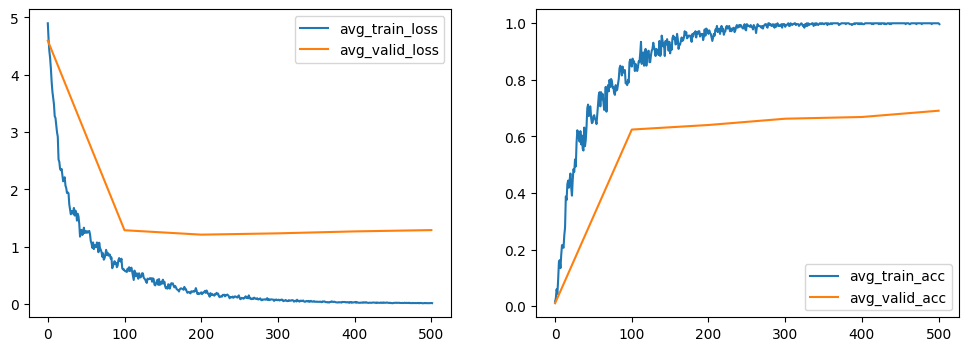

+++++++++++++++++ Average results +++++++++++++++++
Last training loss: 0.02
Last training accuracy: 99.69%
-----------------------------
Last validation loss: 1.29
Last validation accuracy: 69.09%
-----------------------------
(0.02, 1.29) - (99.69%, 69.09%)


In [39]:
# Run the experiment multiple times and average the results
avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, train_iter, valid_iter = average_runs(
     net_params=net_params, LEARNING_RATE = 0.001,
     num_runs = 5, max_iter = 500
)
if True: # Plot
    # Plot averaged results
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter,avg_train_loss, label='avg_train_loss')
    plt.plot(valid_iter,avg_valid_loss, label='avg_valid_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_iter,avg_train_acc, label='avg_train_acc')
    plt.plot(valid_iter,avg_valid_acc, label='avg_valid_acc')
    plt.legend()
    plt.show()

    print("+++++++++++++++++ Average results +++++++++++++++++")
    print_results(avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc)


# Hyperparameter grid search

*Section used to search in a grid for the best hyperparameters. DO NOT TAKE INTO ACCOUNT THE VALUES IN THIS SECTION*

In [51]:
import itertools
import torch.optim as optim
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import numpy as np

VALIDATION_SIZE = 0.1

max_iter = 1000
eval_every = 100


# Define the grid of hyperparameters
param_grid = {
    'lr': [0.001],
    'weight_decay': [0.0, 1e-3, 1e-4],
    'batch_size': [128],
    'rnn_hidden_units': [64],
    'rnn_layers': [16],
    'ffnn_dropout': [0.0],
    'rnn_dropout': [0.2],
    'cnn_kernel_size': [3],
    'cnn_out_channels': [64]
}

# Function to perform grid search with 10 iterations for each parameter set
def grid_search(data, param_grid, num_iterations=10, max_iter=1000):
    best_avg_acc = 0
    best_params = None
    results = []
    
    # Iterate over all combinations of hyperparameters
    for (lr, weight_decay, batch_size, rnn_hidden_units, rnn_layers, ffnn_dropout, rnn_dropout, cnn_kernel_size, cnn_out_channels
         ) in itertools.product(
        param_grid['lr'], 
        param_grid['weight_decay'], 
        param_grid['batch_size'],
        param_grid['rnn_hidden_units'],
        param_grid['rnn_layers'],
        param_grid['ffnn_dropout'],
        param_grid['rnn_dropout'],
        param_grid['cnn_kernel_size'],
        param_grid['cnn_out_channels'],

    ):
        # print(f"Training with lr={lr}, weight_decay={weight_decay}, batch_size={batch_size}, "
            #   f"rnn_layers={rnn_layers}, ffnn_dropout={ffnn_dropout}, rnn_dropout={rnn_dropout}, rnn_hidden_units={rnn_hidden_units}")
        print(f"Training with lr={lr}, weight_decay={weight_decay}, batch_size={batch_size}, "
          f"cnn_out_channels={cnn_out_channels}, ffnn_dropout={ffnn_dropout}")
        
        # Track metrics across multiple iterations
        train_accs_list = []
        train_loss_list = []
        valid_accs_list = []
        valid_loss_list = []
        
        # Perform the training process multiple times
        for iteration in range(num_iterations):
            print(f"Iteration {iteration + 1}/{num_iterations}")
            
            # Initialize network and optimizer
            net = Net(NetParameters(ffnn_dropout=0.5,
                        rnn_layers=16, rnn_bidirectional=False, rnn_dropout=0.2, rnn_only_lastlayer=True,
                        useImages=True, useMarginAndTextures=True, useShapes=True, 
                        kernel_size_1=3,  cnn_stride = 2, cnn_pad=1, pool_1_kernelsize=2, pool_1_stride=2,
                        kernel_size_2=3, pool_2_kernelsize=2, pool_2_stride=2,
                        n_filters=32, cnn_out_channels=64,
                        ffnn_hidden_units=2**10
                        ))

            if use_cuda:
                net.cuda()

            criterion = CrossEntropyLoss()
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
            # Gradient clipping in your training loop
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            # Initialize lists for training and validation
            train_iter, valid_iter = [], []
            train_loss, train_accs = [], []
            valid_loss, valid_accs = [], []
            
            # Generate batches
            batch_gen = data_utils.batch_generator(data,
                                                   batch_size=batch_size,
                                                   num_classes=NUM_CLASSES,
                                                   num_iterations=max_iter,
                                                   seed=42,
                                                   val_size=VALIDATION_SIZE)
            
            net.train()
            for i, batch_train in enumerate(batch_gen.gen_train()):
                if i % eval_every == 0:
                    # Do validation
                    net.eval()
                    val_losses, val_accs, val_lengths = 0, 0, 0
                    for batch_valid, num in batch_gen.gen_valid():
                        output = net(**get_input(batch_valid))
                        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                        
                        val_losses += criterion(output['out'], labels_argmax) * num
                        val_accs += accuracy(output['out'], labels_argmax) * num
                        val_lengths += num

                    # Calculate validation metrics
                    val_losses /= val_lengths
                    val_accs /= val_lengths
                    valid_loss.append(get_numpy(val_losses))
                    valid_accs.append(get_numpy(val_accs))
                    valid_iter.append(i)
                    
                    net.train()
                
                # Train the network
                output = net(**get_input(batch_train))
                labels_argmax = torch.max(get_labels(batch_train), 1)[1]
                batch_loss = criterion(output['out'], labels_argmax)
                
                train_iter.append(i)
                train_loss.append(float(get_numpy(batch_loss)))
                train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
                
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
                
                # Break loop after max iterations
                if max_iter < i:
                    break

            # Track the final training accuracy and loss for this iteration
            train_accs_list.append(train_accs[-1])
            train_loss_list.append(train_loss[-1])
            # Track the final validation accuracy and loss for this iteration
            valid_accs_list.append(valid_accs[-1])
            valid_loss_list.append(valid_loss[-1])
        
        # Calculate average training accuracy and loss over the iterations
        avg_train_acc = np.mean(train_accs_list)
        avg_train_loss = np.mean(train_loss_list)
        # Calculate average validation accuracy and loss over the iterations
        avg_valid_acc = np.mean(valid_accs_list)
        avg_valid_loss = np.mean(valid_loss_list)

        print(f"Avg Training Acc: {avg_train_acc:.4f}, Avg Training Loss: {avg_train_loss:.4f}")
        print(f"Avg Validation Acc: {avg_valid_acc:.4f}, Avg Validation Loss: {avg_valid_loss:.4f}")
        
        # Update best parameters if current combination is better
        if avg_valid_acc > best_avg_acc:
            best_avg_acc = avg_valid_acc
            best_params = {
                'lr': lr, 
                'weight_decay': weight_decay, 
                'batch_size': batch_size, 
                'rnn_hidden_units': rnn_hidden_units,
                'rnn_layers': rnn_layers,
                'ffnn_dropout': ffnn_dropout,
                'rnn_dropout': rnn_dropout
            }
        
        # Store the results for this parameter set
        results.append({
            'lr': lr,
            'weight_decay': weight_decay,
            'batch_size': batch_size,
            'rnn_hidden_units': rnn_hidden_units,
            'rnn_layers': rnn_layers,
            'ffnn_dropout': ffnn_dropout,
            'rnn_dropout': rnn_dropout,
            'avg_train_acc': avg_train_acc,
            'avg_train_loss': avg_train_loss,
            'avg_valid_acc': avg_valid_acc,
            'avg_valid_loss': avg_valid_loss,
        })
    
    print(f"Best params: {best_params} with average accuracy {best_avg_acc:.4f}")
    return best_params, results

# Run grid search
best_params, results = grid_search(data, param_grid, num_iterations=5, max_iter=500)


# Print results of the grid search
for res in results:
    print(f"LR: {res['lr']}, Weight Decay: {res['weight_decay']}, Batch Size: {res['batch_size']}, "
          f"FFNN Dropout: {res['ffnn_dropout']}, " 
          f"\t\t ({res['avg_train_loss']:.2f}, {res['avg_valid_loss']:.2f}) - ({res['avg_train_acc']*100:.2f}%, {res['avg_valid_acc']*100:.2f}%)")


Training with lr=0.001, weight_decay=0.0, batch_size=128, cnn_out_channels=64, ffnn_dropout=0.0
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Avg Training Acc: 1.0000, Avg Training Loss: 0.0011
Avg Validation Acc: 0.9879, Avg Validation Loss: 0.0317
Training with lr=0.001, weight_decay=0.001, batch_size=128, cnn_out_channels=64, ffnn_dropout=0.0
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Avg Training Acc: 1.0000, Avg Training Loss: 0.0101
Avg Validation Acc: 0.9960, Avg Validation Loss: 0.0651
Training with lr=0.001, weight_decay=0.0001, batch_size=128, cnn_out_channels=64, ffnn_dropout=0.0
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Avg Training Acc: 1.0000, Avg Training Loss: 0.0018
Avg Validation Acc: 0.9879, Avg Validation Loss: 0.0359
Best params: {'lr': 0.001, 'weight_decay': 0.001, 'batch_size': 128, 'rnn_hidden_units': 64, 'rnn_layers': 16, 'ffnn_dropout': 0.0, 'rnn_dropout': 0.2} with average accuracy

### RNN

## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 



**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)


#### Description of the final architecture
Here I will explain what has been tried and the process. First of all, we separate the data and the model into only images, only shapes and only margins and textures. Each of these is predicted with a different type of model (CNN + FFNN, RNN + FNN and only FFNN, respectively).
1. *Images*: I first tried a simple one layer CNN. It worked quite well but it was slow. That was due to using 128 pixels images. After reducing to 32 pixels, I was able to try out more complex architectures with more filters. I decided on 5x5 kernel in the first layers and 3x3 in the second (this helps with capturing local and general features), 32 filters in the first layer and 64 in the second. I ended up with 1.29 loss.
2. *Shapes*: I did grid search on parameters sequentially. For the RNN architecture, 16 layers are used and only last layer from the final hidden state is used in the FFNN. Even if keeping all the layers with 16 layers gets better results, it adds too many input sizes and makes the whole thing too slow. Then we select the best RNN dropout and the best RNN Hiddent Units. 
    1. Tests for RNN architecture:
        - All layers, flattening: A lot of parameters, with 16 layers it takes quite a lot of time.
            - rnn_layers=1      (1.07, 2.07) - (66.88%, 51.11%)
            - rnn_layers=2      (0.97, 1.97) - (64.69%, 59.19%)
            - rnn_layers=4      (0.63, 1.77) - (76.56%, 64.24%)
            - rnn_layers=8      (0.46, 1.63) - (84.06%, 64.65%)
            - rnn_layers=16     (0.46, 1.41) - (84.06%, 71.31%)
            - rnn_layers=32     (0.55, 1.35) - (80.00%, 67.88%)
            

        - Last layer, flattening: Good performance, both in time and results.
            - rnn_layers=1      (1.22, 2.01) - (57.50%, 50.51%)
            - rnn_layers=2      (0.70, 2.01) - (75.94%, 60.40%)
            - rnn_layers=4      (0.69, 1.82) - (76.56%, 62.22%)
            - rnn_layers=8      (0.60, 1.68) - (77.81%, 60.61%)
            - rnn_layers=16     (0.61, 1.30) - (79.69%, 67.07%)
            - rnn_layers=32     (4.60, 4.60) - (0.62%, 1.01%)

    2. Tried out different RNN dropout values, the best results are with 0.2 dropout.
        - RNN Dropout: 0.0		 (0.79, 1.51) - (73.12%, 60.61%)
        - RNN Dropout: 0.1	     (0.84, 1.40) - (72.50%, 60.61%)
        - RNN Dropout: 0.2		 (0.87, 1.37) - (71.25%, 62.42%)
        - RNN Dropout: 0.5       (1.22, 1.59) - (56.56%, 54.14%)
        - RNN Dropout: 0.7		 (4.60, 4.60) - (0.62%, 1.01%)
    3. Tried out different RNN Hidden Units, the best results are with the previous 64 hidden units.
        - rnn_hidden_units=8    (2.38, 2.43) - (25.31%, 26.46%)
        - rnn_hidden_units=16   (1.60, 1.73) - (46.88%, 46.26%)
        - rnn_hidden_units=32   (1.12, 1.41) - (58.44%, 59.80%)
        - rnn_hidden_units=64   (0.91, 1.48) - (68.12%, 60.81%)
        - rnn_hidden_units=128  (1.83, 2.24) - (50.62%, 43.84%)
3. *Margins and textures*: Not much to do with this. Improvement in the FFNN will affect everything and it works well in general.
4. *All together*: We add an extra layer with 1024 hidden units (roughly double of what the input) to the FFNN, with 0.5 dropout in between. Also, when we add batchnorm to the results from all the models, the results shoot up.


#### Description of the training parameters
As explained in the batch size section, at first `16` was chosen, but through trial and error, I saw that `128` makes the training faster and the results slightly better. The number of iterations needed are less than 500 but for the prediction we use 1500 since it reduces the loss by $0.01$. I also added gradient clipping.

This section is the one where I experimented the least, since the results from the architecture alone were satisfactory and the values were already pretty standard. So, I left the following as they were:
- Learning Rate: $0.001$
- Momentum: didn't modify anything.
- Weight decay: didn't modify anything. I suspect it would improve the solution but in a limited manner, since batch norm can act as a regularizer.
- Loss function is the same as proposed.
- The only activation function that was tried out was ReLU.
- The only optimzer that was tried out was Adam.

#### Description of the final results
I ended up with `0.03394` score on Kaggle. \
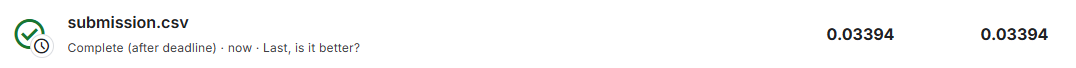

The validation oscilates between `0.02` and `0.04`.

# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [62]:
batch_gen = data_utils.batch_generator(data,
                                            batch_size=128,
                                            num_classes=NUM_CLASSES,
                                            num_iterations=3000,
                                            seed=42,
                                            val_size=VALIDATION_SIZE)

net = Net(NetParameters(ffnn_dropout=0.5,
    rnn_layers=16, rnn_bidirectional=False, rnn_dropout=0.2, rnn_only_lastlayer=True,
    useImages=True, useMarginAndTextures=True, useShapes=True, 
    kernel_size_1=5,  cnn_stride = 2, cnn_pad=1, pool_1_kernelsize=2, pool_1_stride=2,
                                kernel_size_2=3, pool_2_kernelsize=2, pool_2_stride=2,
                                n_filters=32, cnn_out_channels=64,
                              ffnn_hidden_units=2**10))
print(net)

Net(
  (image_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (shape_model): GRU(1, 64, num_layers=16, batch_first=True, dropout=0.2)
  (shape_batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaT_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_model): Sequential(
    (0): Linear(in_features=448, out_features=1024, bias=False)
    (1): ReLU()
    (2): Ba

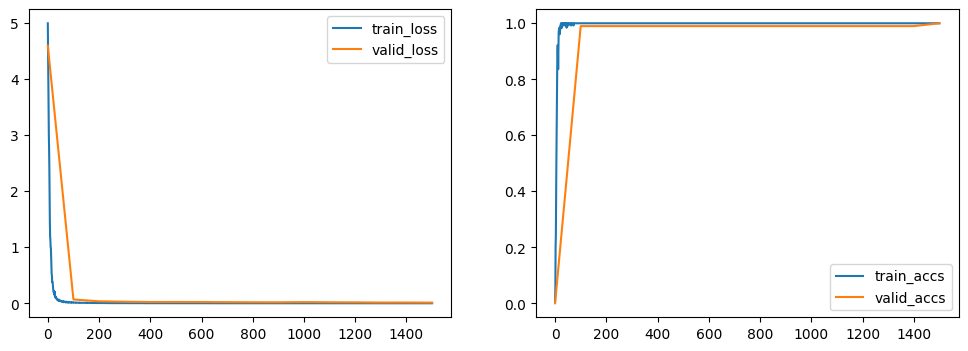

Last training loss: 0.00
Last training accuracy: 100.00%
-----------------------------
Last validation loss: 0.01
Last validation accuracy: 100.00%
-----------------------------
(0.00, 0.01) - (100.00%, 100.00%)


In [63]:

if use_cuda:
    net.cuda()
criterion = CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
train_and_validate(net, batch_gen, criterion, optimizer, max_iter=1500, eval_every=100, log_every=100)
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(torch.exp(y_out).cpu())
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [61]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(local_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.000305,0.000060,0.000019,0.000968,0.000056,0.000032,0.000171,0.000178,0.000082,...,0.000045,0.000523,0.000199,0.000034,0.000069,0.000034,0.000021,0.000284,0.000032,0.000034
1,7,0.000294,0.000142,0.000208,0.001109,0.000185,0.000387,0.003571,0.000298,0.000128,...,0.000136,0.000653,0.000234,0.000215,0.000111,0.000540,0.000241,0.000545,0.000203,0.002947
2,9,0.000331,0.909789,0.000146,0.005327,0.009183,0.000508,0.000361,0.002098,0.004187,...,0.000323,0.000281,0.000313,0.000448,0.000115,0.000592,0.000487,0.000252,0.000212,0.005191
3,12,0.000012,0.000317,0.000015,0.000031,0.000039,0.000017,0.000075,0.000062,0.000167,...,0.000061,0.000104,0.000015,0.000022,0.000041,0.000052,0.001076,0.000025,0.000041,0.000503
4,13,0.000030,0.000315,0.000015,0.000011,0.000145,0.000042,0.000129,0.000026,0.001046,...,0.000351,0.000015,0.000858,0.000037,0.000822,0.000107,0.000177,0.000067,0.000092,0.000030


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 